### Imports

In [14]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact, spearmanr

from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

### Data loading

In [15]:
column_names = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes',
                'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

df = pd.read_csv('../data/breast-cancer.data', header=None, names=column_names, na_values='?')

print(f'Dataset shape: {df.shape}')
print(f'Missing values:\n{df.isnull().sum()}')
print(f'\nFirst 5 rows:')
df.head()

Dataset shape: (286, 10)
Missing values:
Class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64

First 5 rows:


,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


### Global configs

In [16]:
RANDOM_STATE = 42
K_FOLDS = 10
TEST_SIZE = 0.2

ORDINAL_VARS = {
    'age': ['10-19', '20-29', '30-39', '40-49', '50-59',
            '60-69', '70-79', '80-89', '90-99'],
    'tumor-size': ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29',
                   '30-34', '35-39', '40-44', '45-49', '50-54', '55-59'],
    'inv-nodes': ['0-2', '3-5', '6-8', '9-11', '12-14', '15-17',
                  '18-20', '21-23', '24-26', '27-29', '30-32',
                  '33-35', '36-39'],
    'deg-malig': [1, 2, 3]
}

ORDINAL_FEATURES = list(ORDINAL_VARS.keys())
ORDINAL_CATEGORIES = list(ORDINAL_VARS.values())
NOMINAL_FEATURES = ['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat']
CLASS_NAMES = ['no-recurrence-events', 'recurrence-events']

def set_seed(seed=RANDOM_STATE):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

### Utility functions

In [17]:
def compute_metrics(y_true, y_pred):
    """Calcola metriche standard di classificazione."""
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision (macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Recall (macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'F1-score (macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Precision (weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Recall (weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'F1-score (weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
    }


def plot_fold_confusion_matrices(conf_matrices, k, class_names):
    """Mostra le confusion matrix per ogni fold."""
    n_cols = 5
    n_rows = (k + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, (cm, ax) in enumerate(zip(conf_matrices, axes)):
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', ax=ax)
        ax.set_title(f'Fold {i + 1}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    for j in range(len(conf_matrices), len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f'Confusion Matrices ({k} Folds)', fontsize=16)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    legend = '\n'.join([f'{i} = {name}' for i, name in enumerate(class_names)])
    plt.figtext(0.5, 0.01, legend, ha='center', fontsize=11)
    plt.show()


def plot_aggregated_confusion_matrix(conf_matrices, class_names, title='Aggregated Confusion Matrix'):
    """Mostra la confusion matrix aggregata."""
    total_cm = np.sum(conf_matrices, axis=0)
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix=total_cm,
        display_labels=list(range(len(class_names)))
    )
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    legend = ' | '.join([f'{i} = {name}' for i, name in enumerate(class_names)])
    plt.figtext(0.5, -0.06, legend, ha='center', fontsize=11)
    plt.show()


def plot_roc_curve_single(y_true, y_scores, title='ROC Curve'):
    """Plotta la ROC curve da predizioni aggregate."""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_val:.2f})', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return roc_auc_val


def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    """Plotta la Precision-Recall curve."""
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f'PR (AP = {ap:.2f})', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    return ap


def print_metrics_summary(metrics_list, k):
    """Stampa metriche per fold e riassunto con media ± std."""
    df_metrics = pd.DataFrame(metrics_list)

    print(f'\nMetrics per fold:')
    print(df_metrics.to_string(index=False))

    print(f'Average metrics over {k} folds (mean ± std):')
    for col in df_metrics.columns:
        mean = df_metrics[col].mean()
        std = df_metrics[col].std()
        print(f'{col}: {mean:.3f} ± {std:.3f}')

    return df_metrics


def full_evaluation(metrics_list, conf_matrices, y_true_all, y_proba_all,
                    k, class_names, model_name='Model'):
    """Pipeline completa di valutazione."""

    print(f'{model_name} - Evaluation Results')
    df_metrics = print_metrics_summary(metrics_list, k)
    plot_fold_confusion_matrices(conf_matrices, k, class_names)
    plot_aggregated_confusion_matrix(conf_matrices, class_names,
                                     title=f'{model_name} - Aggregated Confusion Matrix')
    roc_auc_val = plot_roc_curve_single(y_true_all, y_proba_all,
                                         title=f'{model_name} - ROC Curve')
    ap = plot_precision_recall_curve(y_true_all, y_proba_all,
                                     title=f'{model_name} - Precision-Recall Curve')

    print(f'\nAUC-ROC: {roc_auc_val:.3f}')
    print(f'Average Precision: {ap:.3f}')

    return df_metrics, roc_auc_val


## Exploratory Data Analysis

Number of samples: 286
Number of features: 9

VARIABLE CLASSIFICATION:
  Ordinal: age, tumor-size, inv-nodes, deg-malig
  Nominal: menopause, node-caps, breast, breast-quad, irradiat

Total missing values: 9
node-caps      8
breast-quad    1
dtype: int64

Target distribution:
                      Count  Percentage
Class                                  
no-recurrence-events    201    70.27972
recurrence-events        85    29.72028


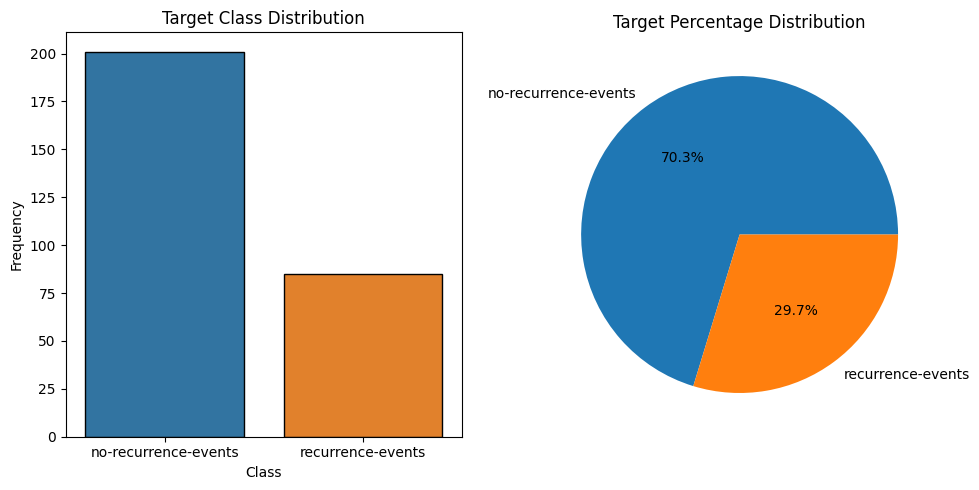

In [18]:
X_raw = df.drop('Class', axis=1)
y_raw = df['Class']

print(f'Number of samples: {X_raw.shape[0]}')
print(f'Number of features: {X_raw.shape[1]}')

# Classificazione delle variabili
feature_types = {
    'Ordinal': ORDINAL_FEATURES,
    'Nominal': NOMINAL_FEATURES,
}
print('\nVARIABLE CLASSIFICATION:')
for ftype, variables in feature_types.items():
    print(f'  {ftype}: {", ".join(variables)}')

# Missing values
missing = df.isnull().sum()
total_missing = missing.sum()
print(f'\nTotal missing values: {total_missing}')
if total_missing > 0:
    print(missing[missing > 0])

# Target distribution
print('\nTarget distribution:')
target_dist = pd.DataFrame({
    'Count': y_raw.value_counts(),
    'Percentage': y_raw.value_counts(normalize=True) * 100
})
print(target_dist)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(x=y_raw, hue=y_raw, edgecolor='black', ax=axes[0], legend=False)
axes[0].set_title('Target Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[1].pie(target_dist['Count'], labels=target_dist.index, autopct='%1.1f%%')
axes[1].set_title('Target Percentage Distribution')
plt.tight_layout()
plt.show()

### Association Analysis

In [19]:
def cramers_v(conf_matrix):
    chi2_val = chi2_contingency(conf_matrix)[0]
    n = conf_matrix.sum().sum()
    phi2 = chi2_val / n
    r, k = conf_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

results = []

for col in X_raw.columns:
    var_type = 'ordinal' if col in ORDINAL_VARS else 'nominal'
    table = pd.crosstab(df[col], df['Class'])

    if table.shape == (2, 2):
        _, p = fisher_exact(table)
    else:
        _, p, _, _ = chi2_contingency(table)

    v = cramers_v(table)

    spearman = np.nan
    if var_type == 'ordinal':
        enc = OrdinalEncoder(categories=[ORDINAL_VARS[col]] if col != 'deg-malig' else 'auto')
        x_enc = enc.fit_transform(df[[col]].dropna())
        y_bin = df.loc[df[col].notna(), 'Class'].apply(lambda val: 1 if val == 'recurrence-events' else 0)
        spearman, _ = spearmanr(x_enc.flatten(), y_bin)

    results.append({
        'Variable': col,
        'Type': var_type,
        'p-value': round(p, 4),
        "Cramer's V": round(v, 3),
        'Spearman': round(spearman, 3) if not np.isnan(spearman) else '-'
    })

results_df = pd.DataFrame(results)
print('Association analysis between features and target:')
print(results_df.to_string(index=False))

Association analysis between features and target:
   Variable    Type  p-value  Cramer's V Spearman
        age ordinal   0.5497       0.118    -0.07
  menopause nominal   0.6732       0.053        -
 tumor-size ordinal   0.0564       0.250    0.182
  inv-nodes ordinal   0.0001       0.317     0.31
  node-caps nominal   0.0000       0.275        -
  deg-malig ordinal   0.0000       0.333    0.303
     breast nominal   0.3648       0.051        -
breast-quad nominal   0.4756       0.111        -
   irradiat nominal   0.0014       0.185        -


### Correlation matrix

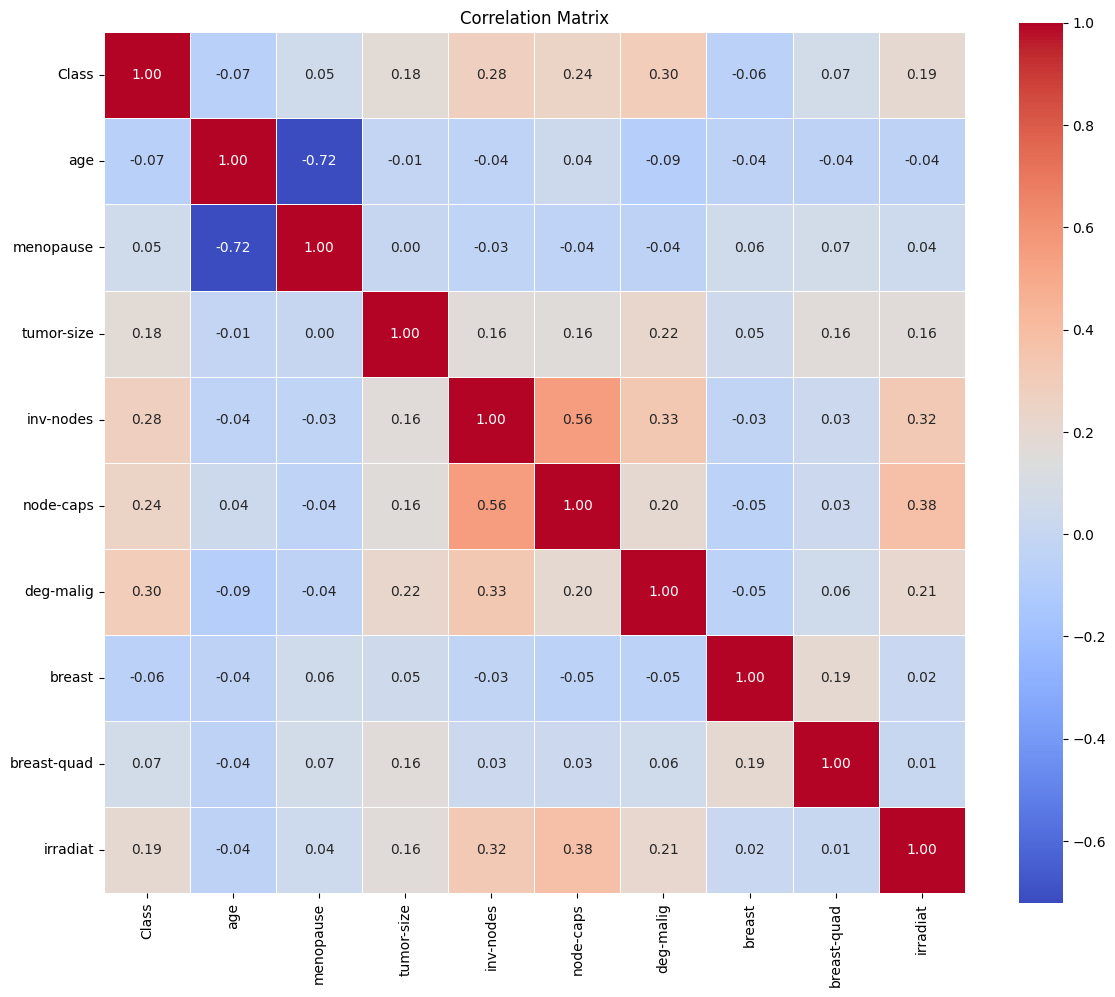


Feature correlations with target:
deg-malig      0.299400
inv-nodes      0.275881
node-caps      0.241480
irradiat       0.193912
tumor-size     0.175065
age           -0.071719
breast-quad    0.066243
breast        -0.058646
menopause      0.052498
Name: Class, dtype: float64

Top 10 inter-feature correlations:
age         menopause   -0.720322
inv-nodes   node-caps    0.555738
node-caps   irradiat     0.380206
inv-nodes   deg-malig    0.329048
            irradiat     0.324176
Class       deg-malig    0.299400
            inv-nodes    0.275881
            node-caps    0.241480
tumor-size  deg-malig    0.218169
deg-malig   irradiat     0.208099
dtype: float64


In [20]:
df_corr = df.copy()
le_temp = LabelEncoder()

oe_temp = OrdinalEncoder(categories=ORDINAL_CATEGORIES)
df_corr[ORDINAL_FEATURES] = oe_temp.fit_transform(df_corr[ORDINAL_FEATURES])

for col in NOMINAL_FEATURES:
    df_corr[col] = le_temp.fit_transform(df_corr[col].astype(str))

df_corr['Class'] = le_temp.fit_transform(df_corr['Class'])

corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

target_corr = corr_matrix['Class'].drop('Class').sort_values(key=abs, ascending=False)
print('\nFeature correlations with target:')
print(target_corr)

upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = upper_tri.stack().sort_values(key=abs, ascending=False)[:10]
print('\nTop 10 inter-feature correlations:')
print(high_corr)

## Preprocessing

In [21]:
df_clean = df.dropna()
print(f'Samples after dropping NaN: {df_clean.shape[0]} (dropped {df.shape[0] - df_clean.shape[0]})')

X = df_clean.drop('Class', axis=1)
y_raw = df_clean['Class']

le = LabelEncoder()
y = le.fit_transform(y_raw)
print(f'Classes: {le.classes_} -> {list(range(len(le.classes_)))}')

# Preprocessor
ordinal_transformer = Pipeline(steps=[
    ('encoder', OrdinalEncoder(
        categories=ORDINAL_CATEGORIES,
        handle_unknown='use_encoded_value',
        unknown_value=-1
    )),
    ('scaler', MinMaxScaler())
])

nominal_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('ord', ordinal_transformer, ORDINAL_FEATURES),
    ('nom', nominal_transformer, NOMINAL_FEATURES)
])


Samples after dropping NaN: 277 (dropped 9)
Classes: ['no-recurrence-events' 'recurrence-events'] -> [0, 1]


### Data saving

In [22]:
data_to_save = {
    'X': X,
    'y': y,
    'preprocessor': preprocessor,
    'le': le,
    'CLASS_NAMES': CLASS_NAMES,
    'ORDINAL_FEATURES': ORDINAL_FEATURES,
    'ORDINAL_CATEGORIES': ORDINAL_CATEGORIES,
    'NOMINAL_FEATURES': NOMINAL_FEATURES,
    'RANDOM_STATE': RANDOM_STATE,
    'K_FOLDS': K_FOLDS
}

with open('../data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)